# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession, DataFrameNaFunctions, Window
from pyspark.sql.functions import udf, asc, desc, col, concat, lit, collect_list, \
                                min, max, avg, stddev, split, first, last, regexp_replace, \
                                weekofyear, year, datediff, dayofyear, date_sub, lag
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.types import IntegerType, StringType, StructField, StructType, LongType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import httpagentparser as hap
% matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [54]:
# load the dataset
df = spark.read.json('medium-sparkify-event-data.json')
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
# evaluate the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# evaluate the dataset
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

#### 数据集评估
1. 该数据集共有543705条记录，每条记录有18列特征，其中六列为数值型特征，其他均为类别特征。
2. 在18个特征中，有9列包含缺失值，其中具有完整身份信息的(姓名、性别、地区、注册号、Agent）共528005行，具有完整歌曲信息的（歌手、歌名、歌曲长度）共432877行。
3. ts和registration特征的数据类型应为时间数据，status的数据类型应为类别数据。
4. location特征中包含了州和市，可进行拆分；userAgent特征中包含了操作系统、浏览器等信息，可进行拆分。

#### 清洗数据集
1. 处理身份信息不完整的行。（歌曲信息不完整是因为访问的页面不是歌曲页面，所以不做处理）
2. 修改错误的数据类型。
3. 从location特征中分离用户所在州。
4. 从userAgent特征中分离用户使用的操作系统和浏览器。

In [6]:
# find the missing value in user's information
df.filter(df.firstName.isNull()).describe().collect()

# 这15700行均无身份信息，无registration，userId均为‘’

[Row(summary='count', artist='0', auth='15700', firstName='0', gender='0', itemInSession='15700', lastName='0', length='0', level='15700', location='0', method='15700', page='15700', registration='0', sessionId='15700', song='0', status='15700', ts='15700', userAgent='0', userId='15700'),
 Row(summary='mean', artist=None, auth=None, firstName=None, gender=None, itemInSession='91.40885350318472', lastName=None, length=None, level=None, location=None, method=None, page=None, registration=None, sessionId='1967.9756050955414', song=None, status='241.20184713375795', ts='1.5408842797871975E12', userAgent=None, userId=None),
 Row(summary='stddev', artist=None, auth=None, firstName=None, gender=None, itemInSession='110.7026037346012', lastName=None, length=None, level=None, location=None, method=None, page=None, registration=None, sessionId='1443.9082796085377', song=None, status='52.262276278215914', ts='1.5073579015081034E9', userAgent=None, userId=None),
 Row(summary='min', artist=None, au

In [7]:
# 猜测是还未注册的用户，所以这部分不在我们分析的范畴内，将这些行删除。
df = df.filter(df.userId != '')

In [8]:
# 歌曲信息缺失是由于浏览的不是歌曲界面，所以不用进行缺失值处理
df.filter(df.artist.isNull()).groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   99|
|    Submit Downgrade|  117|
|         Thumbs Down| 4911|
|                Home|19089|
|           Downgrade| 3811|
|         Roll Advert| 7773|
|              Logout| 5990|
|       Save Settings|  585|
|Cancellation Conf...|   99|
|               About| 1026|
|            Settings| 2964|
|     Add to Playlist|12349|
|          Add Friend| 8087|
|           Thumbs Up|23826|
|                Help| 2644|
|             Upgrade|  968|
|               Error|  503|
|      Submit Upgrade|  287|
+--------------------+-----+



In [9]:
# define to_string function
to_string = udf(lambda x: str(x), StringType())

In [10]:
# change the data type of 'status'
df = df.withColumn('status_str', to_string(df.status))

In [11]:
# define the to_date function
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1e3).strftime('%Y-%m-%d %H:%M:%S'))

In [12]:
# change the data type of 'ts' and 'registration'
df = df.withColumn('regist_date', to_date(df.registration))
df = df.withColumn('log_date', to_date(df.ts))

In [13]:
# define find_state function
find_state = udf(lambda x: x.split(',')[-1][1:3], StringType())

In [14]:
# create the state feature
df = df.withColumn('state', find_state(df.location))

In [15]:
# define find_os function and find_browser function
find_os =  udf(lambda x: hap.simple_detect(x)[0], StringType())
find_browser = udf(lambda x: hap.simple_detect(x)[1], StringType())

In [16]:
# create os and browser features
df = df.withColumn('os', find_os(df.userAgent))
df = df.withColumn('browser', find_browser(df.userAgent))

In [17]:
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', status_str='200', regist_date='2018-07-20 13:11:47', log_date='2018-10-01 08:00:11', state='TX', os='MacOS Macintosh X 10.9.4', browser='Chrome 36.0.1985.125'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleW

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [18]:
# define churn actions
is_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
# create the churn column
df = df.withColumn('churn', is_churn(df.page))

In [19]:
# get all the churn users'ID
churn_users = df.filter(df.churn == 1).select(collect_list('userId')).first()[0]

# define churn users
is_churn_user = udf(lambda x: 1 if x in churn_users else 0, IntegerType())

# create the churn_user column
df = df.withColumn('churn_user', is_churn_user(df.userId))

#### 探索性数据分析
1. sparkify上共有多少用户，其中男性和女性用户各占多少？
2. 目前共有多少付费用户，多少免费用户？付费用户中男性。女性用户各多少？
3. 有多少流失用户？其中付费和免费用户各占多少？
4. 正常用户和流失用户各使用sparkify多长时间？
5. 正常用户和流失用户各自偏好浏览哪些页面？
6. 地点对于客户流失的影响？
7. 操作系统和浏览器对于用户流失的影响？
8. 正常用户和流失用户各使用了几次？
9. 正常用户和流失用户每次平均使用多长时间？
10. 正常用户和流失用户每次使用浏览页面数量？
11. 正常用户和流失用户每次使用听歌数量？
12. 正常用户和流失用户每次使用听歌页面占浏览页面的比例分别是多少？
13. 正常用户和流失用户最新一次使用时对各类页面的访问比例
14. 正常用户和流失用户每次使用的间隔时间？

In [20]:
# 1. sparkify上共有多少用户，其中男性和女性用户各占多少？
df.select(['userId','gender']).dropDuplicates().groupBy('gender').count().collect()

# 共计448个用户， 其中198个女性用户，250个男性用户

[Row(gender='F', count=198), Row(gender='M', count=250)]

In [21]:
# 2. 目前共有多少付费用户，多少免费用户？付费用户中男性。女性用户各多少？
## 计算用户最新level状态
w1 = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn('now_level', first('level').over(w1))

In [22]:
## 计算付费用户和免费用户数量
df.select(['userId','now_level']).dropDuplicates().groupBy('now_level').count().collect()

# 448个用户中，目前付费用户276个，免费用户172个

[Row(now_level='free', count=172), Row(now_level='paid', count=276)]

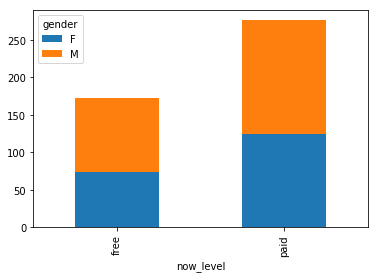

In [23]:
## 用户level和用户性别
level_gender_df = df.select(['userId','gender','now_level']).dropDuplicates() \
                    .groupby(['now_level','gender']).count().toPandas()
level_gender_df.pivot('now_level','gender','count').plot(kind = 'bar', stacked = True)

In [24]:
# 3. 有多少流失用户？其中付费和免费用户各占多少？
## 流失用户数量
df.select(['userId','churn_user']).dropDuplicates().groupBy('churn_user').count().collect()

# 在448个用户中，流失用户为99个

[Row(churn_user=1, count=99), Row(churn_user=0, count=349)]

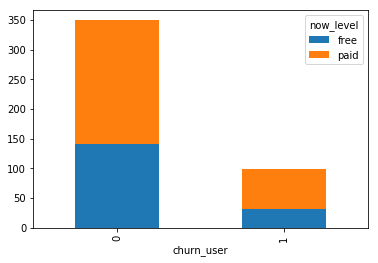

In [25]:
## 流失用户中付费和免费用户比例
churn_level_df = df.select(['userId','churn_user','now_level']).dropDuplicates() \
                    .groupBy(['churn_user','now_level']).count().toPandas()
churn_level_df.pivot('churn_user', 'now_level','count').plot(kind = 'bar', stacked = True)

# 99个流失用户中67个付费用户，32个免费用户；付费用户在流失用户中的比例高于正常用户

In [26]:
# 4. 正常用户和流失用户各使用sparkify多长时间？
## 根据regist_date和最新的log_date 计算用户使用时长
df = df.withColumn('days_since_regist',datediff(df.log_date, df.regist_date))
## 提取正常用户使用时长数据集
days_used_unchurn = df.filter(df.churn_user == 0) \
                        .select(['userId', 'days_since_regist']) \
                        .groupby('userId').max().toPandas()
days_used_churn = df.filter(df.churn_user == 1) \
                        .select(['userId', 'days_since_regist']) \
                        .groupby('userId').max().toPandas()

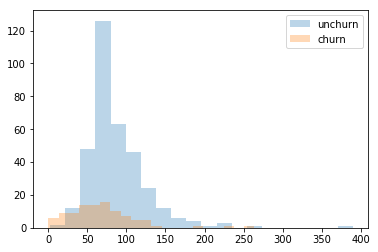

In [27]:
fig, ax = plt.subplots()
ax.hist(days_used_unchurn['max(days_since_regist)'], label = 'unchurn', alpha = 0.3, bins = 20)
ax.hist(days_used_churn['max(days_since_regist)'], label = 'churn', alpha = 0.3, bins = 20)
plt.legend()

# 从图片上看出，无论是流失用户还是正常用户，注册时间在50~100天左右的用户在所有用户中所占比例最大；
# 正常用户的平均使用天数多于流失用户的平均实用天数；
# 流失用户的分布形状与正常用户的分布形状不同，正常用户呈现一定的右尾形状，流失用户基本呈现正态分布；
# 在流失用户中，注册50天以内的新用户比例明显高于正常用户

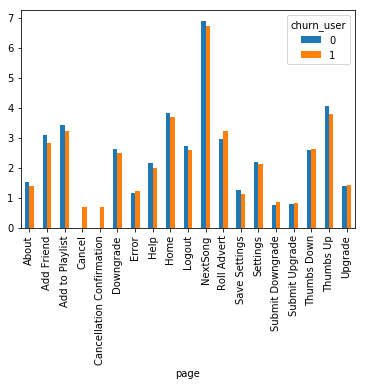

In [28]:
# 5. 正常用户和流失用户各自偏好浏览哪些页面？
## 将流失用户和正常用户对不同页面的访问数量提取得到新的数据集page_df
page_df = df.groupBy(['churn_user','userId','page']).count() \
            .orderBy(['page','churn_user'], ascending = True)
## 计算流失用户和正常用户对某一页面的平均访问次数
page_df = page_df.groupby(['page','churn_user']).mean().toPandas()
## 对数据集进行转化并作图（因为不同页面访问数量差异较大，对数量取对数）
page_df['avg(count)'] = np.log(page_df['avg(count)'] + 1)
page_df.pivot('page','churn_user','avg(count)').fillna(0).plot(kind = 'bar')

# 通过图片得到以下信息：
## 1）Cancel和 Cancellation Comfirmation两个页面是流失用户的标记页面；
## 2）流失用户对Error、Roll Advert和Thrumbs Down三个页面访问次数高于正常用户，猜测流失用户可能具有更为不好的用户体验；
## 3）流失用户对Submit Upgrade, Upgrade, Submit Downgrade三个页面的访问次数略高于正常用户，
##    猜测流失用户可能试图通过调整级别来改善使用体验；
## 4）正常用户的Add Friend， Add to Playlist, NextSong, Thrumbs Up等页面访问次数明显高于流失用户，
##    说明正常用户与sparkify应用的积极互动更多，更为活跃；

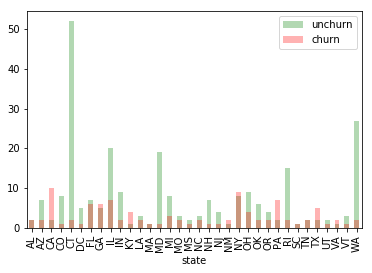

In [29]:
# 6. 地点对于客户流失的影响？
## 流失客户的Roll Advert页面更多, 猜测广告的投放数量可能与用户所在地区有关
## 提取用户地点数据集
user_state_df = df.select(['churn_user','userId','state']).dropDuplicates().toPandas()

## 对不同地点的流失用户比例作图
user_state_df[user_state_df.churn_user == 0].groupby(['state'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'green', label = 'unchurn', alpha = 0.3)
user_state_df[user_state_df.churn_user == 1].groupby(['state'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'red', label = 'churn', alpha = 0.3)
plt.legend()

# 下图显示，不同地区的流失用户比例出现较大差异，CT/MD/WA等地区流失用户比例非常低，CA/KY/PA等地区的流失用户比例非常高。

In [30]:
# 7. 操作系统和浏览器对于用户流失的影响？
## 流失用的Error访问页面高于正常用户，这可能是Sparkify与这些用户的使用终端不兼容导致的，因此探索一下操作系统和浏览器对于用户流失的影响。

## 提取用户使用的终端数据集
userAgent_df = df.select(['churn_user','userId', 'os', 'browser']).dropDuplicates().toPandas()

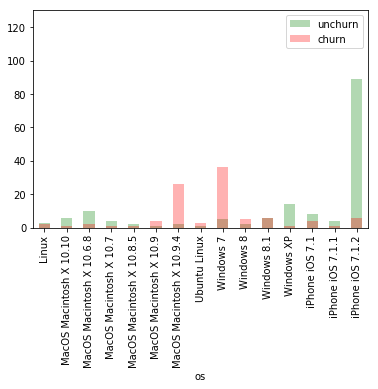

In [31]:
## 在不同操作系统上用户流失的比例
userAgent_df[userAgent_df.churn_user == 0].groupby(['os'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'green', label = 'unchurn', alpha = 0.3)
userAgent_df[userAgent_df.churn_user == 1].groupby(['os'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'red', label = 'churn', alpha = 0.3)
plt.legend()

# 下图显示在不同的操作系统上用户流失比例显著不同，如在iphone ios 7.1.2上用户流失的比例非常低，在windows 7上用户流失的比例非常高。

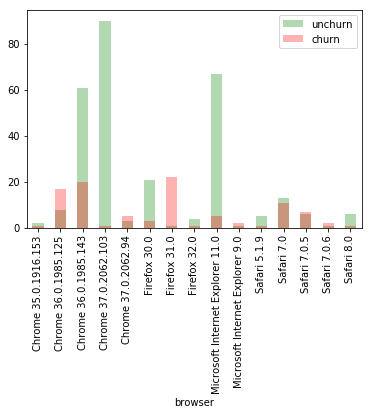

In [32]:
## 使用不同浏览器对用户流失的影响
userAgent_df[userAgent_df.churn_user == 0].groupby(['browser'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'green', label = 'unchurn', alpha = 0.3)
userAgent_df[userAgent_df.churn_user == 1].groupby(['browser'])['userId'].count() \
        .sort_index().plot(kind = 'bar', color = 'red', label = 'churn', alpha = 0.3)
plt.legend()

# 下图显示使用不同浏览器的用户流失比例具有显著差异，如使用chrome 37.0.2062.94的用户流失比例非常低，而使用firefox 31.0的用户流失比例非常高。

In [33]:
# 随机选取一个用户，查看该用户itemInSession，sessionId等参数的意义
df.filter(df.userId == '100') \
    .orderBy(asc('ts')) \
    .select(['auth','itemInSession','page','sessionId','log_date','ts']) \
    .take(500)
# 发现sessionId是用户每次使用sparkify时，系统设定的一个值，每次使用该值保持不变；
# itemInSession是在本次使用过程中，依次访问的页面编号；
# 每次layout，itemInSession会损失两个编号。

[Row(auth='Logged In', itemInSession=0, page='Home', sessionId=497, log_date='2018-10-01 08:04:01', ts=1538352241000),
 Row(auth='Logged In', itemInSession=1, page='NextSong', sessionId=497, log_date='2018-10-01 08:04:19', ts=1538352259000),
 Row(auth='Logged In', itemInSession=2, page='NextSong', sessionId=497, log_date='2018-10-01 08:07:40', ts=1538352460000),
 Row(auth='Logged In', itemInSession=3, page='Roll Advert', sessionId=497, log_date='2018-10-01 08:07:40', ts=1538352460000),
 Row(auth='Logged In', itemInSession=4, page='NextSong', sessionId=497, log_date='2018-10-01 08:10:47', ts=1538352647000),
 Row(auth='Logged In', itemInSession=5, page='Roll Advert', sessionId=497, log_date='2018-10-01 08:10:50', ts=1538352650000),
 Row(auth='Logged In', itemInSession=6, page='NextSong', sessionId=497, log_date='2018-10-01 08:14:30', ts=1538352870000),
 Row(auth='Logged In', itemInSession=7, page='Roll Advert', sessionId=497, log_date='2018-10-01 08:15:02', ts=1538352902000),
 Row(auth='

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x14fc17d6a58>,
 'caps': [<matplotlib.lines.Line2D at 0x14fc1803358>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fc17d6908>,
 'medians': [<matplotlib.lines.Line2D at 0x14fc1803ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fc1803fd0>,
 'means': []}

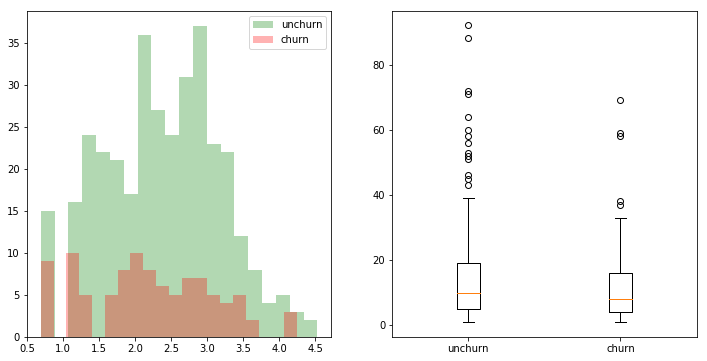

In [34]:
# 8. 正常用户和流失用户各使用了几次？
## 提取用户使用信息数据集
df_session_count = df.select(['churn_user', 'userId','sessionId']).dropDuplicates() \
                    .groupBy(['churn_user', 'userId']).count().toPandas().drop('userId', axis = 1)

## 对正常用户和流失用户的使用次数分布进行作图
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].hist(np.log(df_session_count[df_session_count.churn_user == 0]['count'] + 1), \
           label = 'unchurn', color = 'g', alpha = 0.3, bins = 20)
ax[0].hist(np.log(df_session_count[df_session_count.churn_user == 1]['count'] + 1), \
           label = 'churn', color = 'r', alpha = 0.3, bins = 20)
ax[0].legend()
ax[1].boxplot([df_session_count[df_session_count.churn_user == 0]['count'], \
               df_session_count[df_session_count.churn_user == 1]['count']], \
              labels = ['unchurn', 'churn'])

# 下图显示正常用户的使用次数比流失用户略高一点，这也许与流失用户使用总时间短有关。

In [35]:
# 9. 正常用户和流失用户每次平均使用多长时间？
## 提取每次使用时间数据集
session_length_df = df.select(['churn_user', 'userId','sessionId','ts']).toPandas()

In [36]:
## 计算每个用户每次使用时长
session_length_per_user = session_length_df.sort_values(by = ['churn_user', 'userId', 'sessionId', 'ts'], ascending = True) \
    .groupby(['churn_user', 'userId', 'sessionId']).last() \
    - session_length_df.sort_values(by = ['churn_user', 'userId', 'sessionId', 'ts'], ascending = True) \
    .groupby(['churn_user', 'userId', 'sessionId']).first()

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


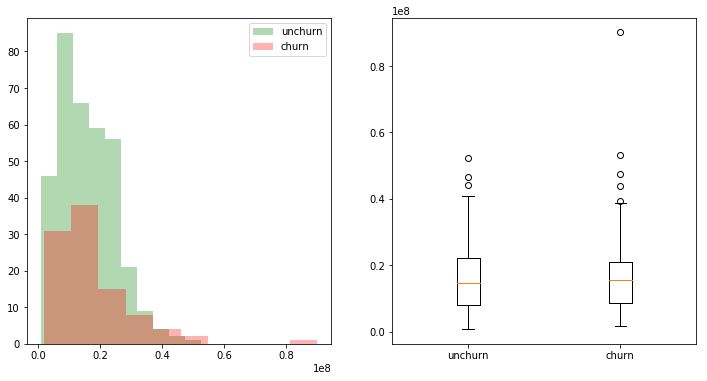

In [37]:
## 对正常用户和流失用户每次使用时长的分布作图
fig, ax = plt.subplots(1,2, figsize = (12,6));
ax[0].hist(session_length_per_user[session_length_per_user.index.get_level_values(0) == 0].mean(level = 1)['ts'], \
            label = 'unchurn', color = 'g', alpha = 0.3);
ax[0].hist(session_length_per_user[session_length_per_user.index.get_level_values(0) == 1].mean(level = 1)['ts'], \
            label = 'churn', color = 'r', alpha = 0.3)
ax[0].legend();
ax[1].boxplot([session_length_per_user[session_length_per_user.index.get_level_values(0) == 0].mean(level = 1)['ts'], \
              session_length_per_user[session_length_per_user.index.get_level_values(0) == 1].mean(level = 1)['ts']], \
    labels = ['unchurn', 'churn']);


# 下图显示流失用户每次使用的平均时长略高于正常用户。

In [38]:
# 10. 正常用户和流失用户每次使用浏览页面数量？
## 创建正常用户每次使用浏览页面数量数据集
item_session_df = df.select(['churn_user', 'userId', 'sessionId', 'itemInSession']) \
    .groupBy(['churn_user', 'userId', 'sessionId']).max().toPandas()

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


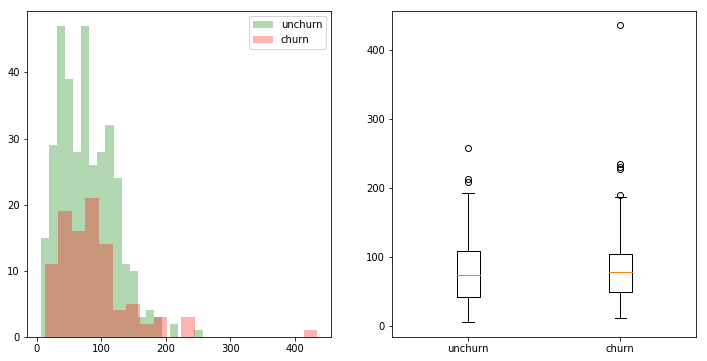

In [39]:
## 对浏览页面数量分布情况作图
fig, ax = plt.subplots(1,2, figsize = (12,6));
ax[0].hist(item_session_df[item_session_df.churn_user == 0].groupby('userId')['max(itemInSession)'].mean(), \
           label = 'unchurn', color = 'g', alpha = 0.3, bins = 20);
ax[0].hist(item_session_df[item_session_df.churn_user == 1].groupby('userId')['max(itemInSession)'].mean(), \
           label = 'churn', color = 'r', alpha = 0.3,bins = 20);
ax[0].legend();
ax[1].boxplot([item_session_df[item_session_df.churn_user == 0].groupby('userId')['max(itemInSession)'].mean(), \
               item_session_df[item_session_df.churn_user == 1].groupby('userId')['max(itemInSession)'].mean()], \
             labels = ['unchurn', 'churn']);

# 下图可以看出流失用户和正常用户每次使用浏览页面的数量分布相似；
# 流失用户访问页面数量的略高于正常用户的访问数量.

In [40]:
# 11. 正常用户和流失用户每次使用听歌数量？
## 定义是否听歌函数
is_song = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
## 创建song特征列
df = df.withColumn('song', is_song(df.page))
## 提取每次听歌数据集
songs_per_session = df.select(['churn_user', 'userId', 'sessionId', 'song']) \
                    .groupBy(['churn_user', 'userId', 'sessionId']).sum().toPandas()

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x14fc66dd7b8>,
 'caps': [<matplotlib.lines.Line2D at 0x14fc6e390b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fc66dd668>,
 'medians': [<matplotlib.lines.Line2D at 0x14fc6e39908>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fc6e39d30>,
 'means': []}

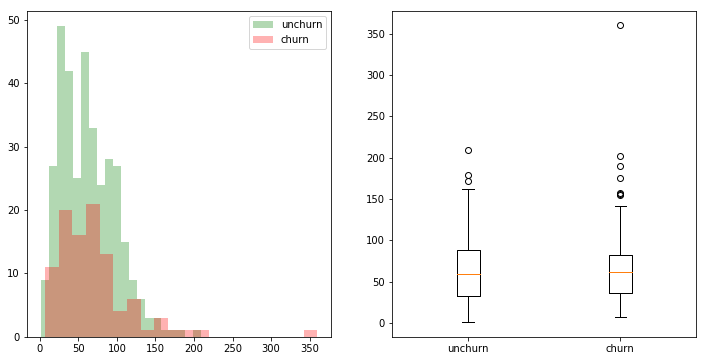

In [41]:
## 对正常用户和流失用户每次使用听歌数量的分布情况作图
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].hist(songs_per_session[songs_per_session['churn_user'] == 0] \
           .groupby('userId')['sum(song)'].mean(), label = 'unchurn', color = 'g', alpha = 0.3, bins = 20)
ax[0].hist(songs_per_session[songs_per_session['churn_user'] == 1] \
           .groupby('userId')['sum(song)'].mean(), label = 'churn', color = 'r', alpha = 0.3, bins = 20)
ax[0].legend();
ax[1].boxplot([songs_per_session[songs_per_session['churn_user'] == 0] \
               .groupby('userId')['sum(song)'].mean(), \
              songs_per_session[songs_per_session['churn_user'] == 1] \
               .groupby('userId')['sum(song)'].mean()], \
             labels = ['unchurn','churn'])

## 下图显示流失用户每次使用的平均听歌数量略高于正常用户

In [42]:
# 12. 正常用户和流失用户每次使用听歌页面占浏览页面的比例分别是多少？
## 提取每次使用听歌和页面总数数据集
item_songs_per_session = df.select(['churn_user', 'userId', 'sessionId', 'itemInSession', 'song']) \
                        .orderBy(['churn_user', 'userId', 'sessionId']).toPandas()

In [43]:
## 对正常用户和流失用户分别计算听歌页面占浏览页面的比例
songs_ratio_unchurn = (item_songs_per_session[item_songs_per_session.churn_user == 0] \
                       .groupby(['userId', 'sessionId'])['song'].sum() \
                       /(item_songs_per_session[item_songs_per_session.churn_user == 0] \
                         .groupby(['userId', 'sessionId'])['itemInSession'].max() + 1)) \
                        .fillna(0)
songs_ratio_churn = (item_songs_per_session[item_songs_per_session.churn_user == 1] \
                     .groupby(['userId', 'sessionId'])['song'].sum() \
                     /(item_songs_per_session[item_songs_per_session.churn_user == 1] \
                       .groupby(['userId', 'sessionId'])['itemInSession'].max() + 1)) \
                        .fillna(0)

{'whiskers': [<matplotlib.lines.Line2D at 0x14fcae4cf60>,
 'caps': [<matplotlib.lines.Line2D at 0x14fcae67860>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fcae4ce10>,
 'medians': [<matplotlib.lines.Line2D at 0x14fcae620f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fcae62518>,
 'means': []}

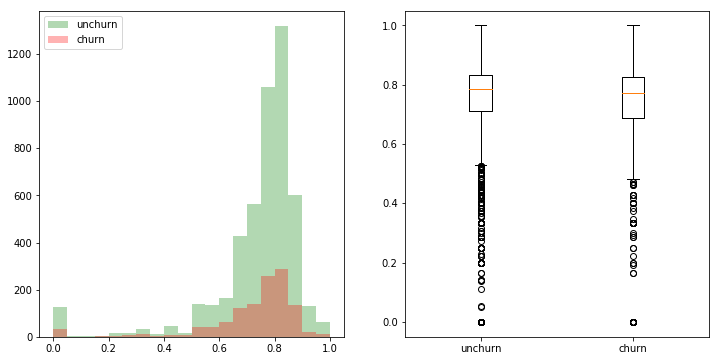

In [44]:
## 对正常用户和流失用户每次使用听歌页面占总浏览页面的比例进行作图
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].hist(songs_ratio_unchurn.values, label = 'unchurn', color = 'g', alpha = 0.3, bins = 20)
ax[0].hist(songs_ratio_churn.values, label = 'churn', color = 'r', alpha = 0.3, bins = 20)
ax[0].legend();
ax[1].boxplot([songs_ratio_unchurn.values, \
              songs_ratio_churn.values], \
             labels = ['unchurn','churn'])

## 下图可以看出正常用户每次使用听歌页面占所有访问页面的比例略高于流失用户的该比例。

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x14fc9cf30b8>,
 'caps': [<matplotlib.lines.Line2D at 0x14fc9cf3978>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fc9ce6f28>,
 'medians': [<matplotlib.lines.Line2D at 0x14fc9cfd208>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fc9cfd630>,
 'means': []}

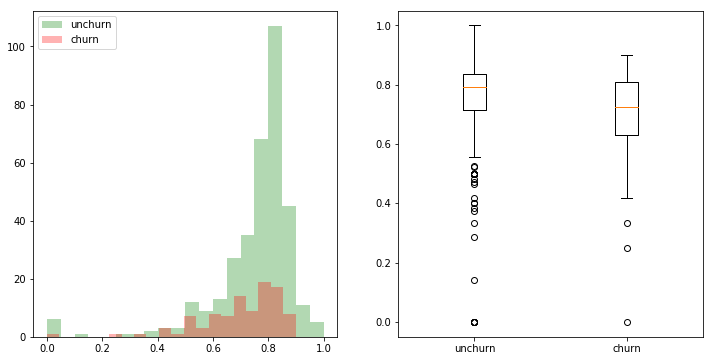

In [45]:
## 流失用户曾经也是正常用户，因此对用户每一次使用时听歌页面所占比例都进行分析可能会掩盖正常用户和流失用户的差异;
## 因此尝试对比正常用户和流失用户最近一次使用时听歌页面占浏览页面的比例
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].hist(songs_ratio_unchurn.groupby(level = [0]).last(), \
           label = 'unchurn', color = 'g', alpha = 0.3, bins = 20)
ax[0].hist(songs_ratio_churn.groupby(level = [0]).last(), \
           label = 'churn', color = 'r', alpha = 0.3, bins = 20)
ax[0].legend();
ax[1].boxplot([songs_ratio_unchurn.groupby(level = [0]).last(), \
              songs_ratio_churn.groupby(level = [0]).last()], \
             labels = ['unchurn','churn'])

## 下图可以看出正常用户最近一次使用其听歌页面占所有访问页面的比例显著高于流失用户的该比例。

我们发现无论是正常用户还是流失用户，每次使用NextSong页面占据总浏览页面的70%~80%，这说明其他页面的访问比例相对很小；我们按照之前对page页面的总体分析结果将page页面中各个页面划分为积极互动类页面（包括Add to Playlist, Add Friend, Thumbs Up）、体验差类页面（包括Error, Roll Advert, Thumbs Down）、调整级别类页面（包括Upgrade, Downgrade, Submit Upgrade, Submit Downgrade）和其他页面（剩余页面）；分别计算正常用户和流失用户最新一次登录对上述几类页面的访问比例。

In [46]:
# 13. 正常用户和流失用户最新一次使用时对各类页面的访问比例
## 定义各类页面
act_pages = ['Add to Playlist', 'Add Friend', 'Thumbs Up']
bad_pages = ['Error', 'Roll Advert', 'Thumbs Down']
adjust_pages = ['Upgrade', 'Downgrade', 'Submit Upgrade', 'Submit Downgrade']

## 定义计算各类页面的函数
is_active = udf(lambda x : 1 if x in act_pages else 0, IntegerType())
is_bad = udf(lambda x : 1 if x in bad_pages else 0, IntegerType())
is_adjust = udf(lambda x : 1 if x in adjust_pages else 0, IntegerType())

## 创建各类页面的特征列
df = df.withColumn('active', is_active(df.page))
df = df.withColumn('bad', is_bad(df.page))
df = df.withColumn('adjust', is_adjust(df.page))

In [47]:
## 提取用户访问各类页面的数据集
pages_ratio_df = df.select(['churn_user', 'userId', 'sessionId', 'itemInSession', 'active', 'bad', 'adjust']) \
                    .orderBy(['churn_user', 'userId', 'sessionId']).toPandas()

In [48]:
## 计算正常用户和流失用户最近一次使用访问的页面总数
items_unchurn = pages_ratio_df[pages_ratio_df.churn_user == 0].groupby('userId').last()['itemInSession'] + 1
items_churn = pages_ratio_df[pages_ratio_df.churn_user == 1].groupby('userId').last()['itemInSession'] + 1

In [49]:
## 计算正常用户和流失用户最近一次使用时各类页面的访问次数
pages_unchurn = pages_ratio_df[pages_ratio_df.churn_user == 0] \
                .groupby(['userId', 'sessionId']).sum() \
                .groupby(level = [0]).last() \
                .drop(['churn_user', 'itemInSession'], axis = 1)
pages_churn = pages_ratio_df[pages_ratio_df.churn_user == 1] \
                .groupby(['userId', 'sessionId']).sum() \
                .groupby(level = [0]).last() \
                .drop(['churn_user', 'itemInSession'], axis = 1)

In [50]:
## 计算正常用户和流失用户最近一次使用时各类页面的访问比例
pages_ratio_unchurn = np.divide(pages_unchurn, items_unchurn.reshape((items_unchurn.shape[0],1)))
pages_ratio_churn = np.divide(pages_churn, items_churn.reshape((items_churn.shape[0],1)))

C:\Users\j-hua\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
C:\Users\j-hua\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x14fca9710b8>,
 'caps': [<matplotlib.lines.Line2D at 0x14fca971978>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fca961f28>,
 'medians': [<matplotlib.lines.Line2D at 0x14fcaa46208>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fcaa46630>,
 'means': []}

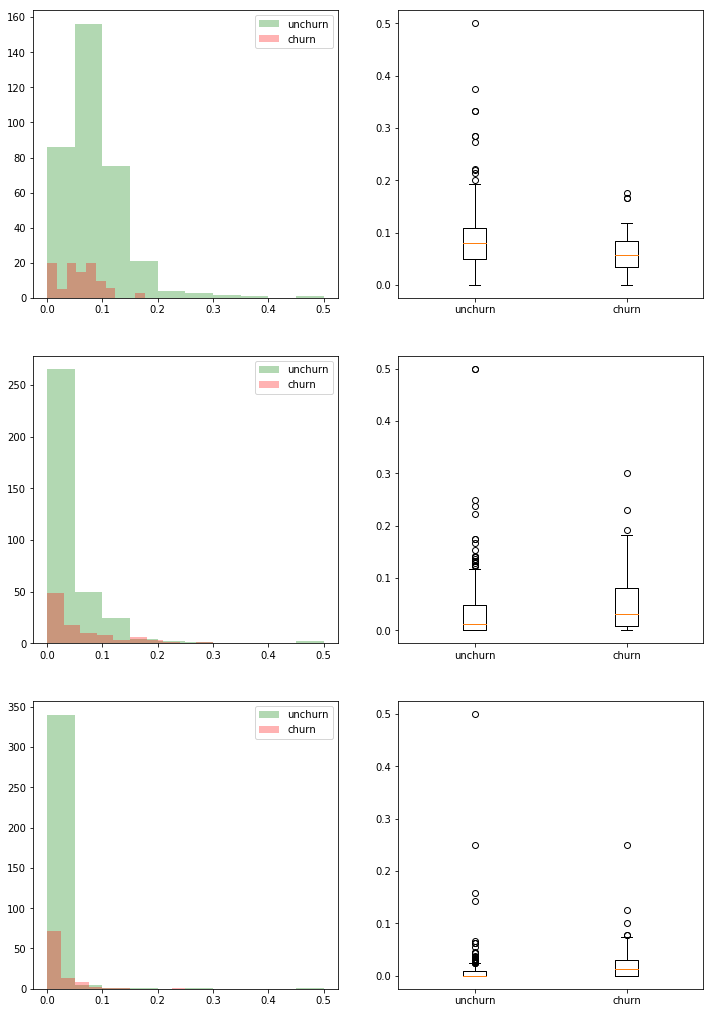

In [51]:
## 对正常用户和流失用户对各类页面的访问比例的分布作图
fig, ax = plt.subplots(3,2, figsize = (12,18))
ax[0][0].hist(pages_ratio_unchurn['active'], label = 'unchurn', color = 'g', alpha = 0.3)
ax[0][0].hist(pages_ratio_churn['active'], label = 'churn', color = 'r', alpha = 0.3)
ax[0][0].legend()
ax[0][1].boxplot([pages_ratio_unchurn['active'],pages_ratio_churn['active']] , labels = ['unchurn', 'churn'])
ax[1][0].hist(pages_ratio_unchurn['bad'], label = 'unchurn', color = 'g', alpha = 0.3)
ax[1][0].hist(pages_ratio_churn['bad'], label = 'churn', color = 'r', alpha = 0.3)
ax[1][0].legend()
ax[1][1].boxplot([pages_ratio_unchurn['bad'],pages_ratio_churn['bad']] , labels = ['unchurn', 'churn'])
ax[2][0].hist(pages_ratio_unchurn['adjust'], label = 'unchurn', color = 'g', alpha = 0.3)
ax[2][0].hist(pages_ratio_churn['adjust'], label = 'churn', color = 'r', alpha = 0.3)
ax[2][0].legend()
ax[2][1].boxplot([pages_ratio_unchurn['adjust'],pages_ratio_churn['adjust']] , labels = ['unchurn', 'churn'])

# 下图显示，正常用户最近一次使用积极互动类页面访问比例高于流失用户的该比例；
# 正常用户最近一次使用体验差类页面访问比例低于流失用户的该比例；
# 正常用户最近一次使用调整级别类页面访问比例低于流失用户的该比例；

In [52]:
# 14. 正常用户和流失用户每次使用的间隔时间？
## 提取用户使用时间数据集
time_df = df.select(['churn_user', 'userId', 'sessionId', 'ts']) \
            .groupBy(['churn_user', 'userId', 'sessionId']) \
            .agg(min('ts').alias('begin'), max('ts').alias('end')) \
            .orderBy(['churn_user', 'userId', 'sessionId'])
## 删除其中只使用一次的用户
new = time_df.groupBy('userId').count()
morethan2sessions_users = new.filter(col('count') > 1).select(collect_list('userId')).first()[0]
is_more_than2 = udf(lambda x: 1 if x in morethan2sessions_users else 0, IntegerType())
time_df = time_df.withColumn('2+', is_more_than2(time_df.userId)).filter(col('2+') == 1)
## 计算用户每次使用与上次使用的间隔时间
w1 = Window.partitionBy('userId').orderBy('sessionId')
timestamp_df = time_df.withColumn('last_end', lag(col('end')).over(w1)) \
                .withColumn('timestamp', col('begin') - col('last_end'))
## 计算用户最近两次使用的间隔时间
w2 = Window.partitionBy('userId').orderBy('sessionId') \
            .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
timestamp_df = timestamp_df.withColumn('newest_timestamp', last(col('timestamp')).over(w2)) \
                .select(['churn_user', 'userId', 'newest_timestamp']).dropDuplicates().toPandas()

C:\Users\j-hua\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x14fc8bdb400>,
 'caps': [<matplotlib.lines.Line2D at 0x14fc8bdbcc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14fc8bdb2b0>,
 'medians': [<matplotlib.lines.Line2D at 0x14fc8bee550>,
 'fliers': [<matplotlib.lines.Line2D at 0x14fc8bee978>,
 'means': []}

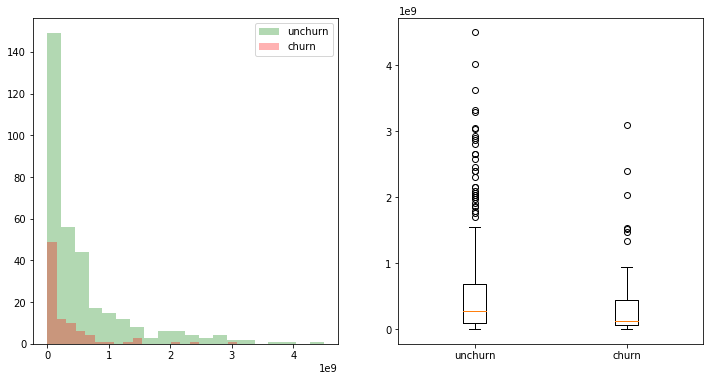

In [53]:
## 对正常用户和流失用户最近两次使用的时间间隔进行作图
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].hist(timestamp_df[timestamp_df.churn_user == 0].newest_timestamp, \
           label = 'unchurn', color = 'g', alpha = 0.3, bins = 20)
ax[0].hist(timestamp_df[timestamp_df.churn_user == 1].newest_timestamp, \
           label = 'churn', color = 'r', alpha = 0.3, bins = 20)
ax[0].legend();
ax[1].boxplot([timestamp_df[timestamp_df.churn_user == 0].newest_timestamp, \
              timestamp_df[timestamp_df.churn_user == 1].newest_timestamp], \
             labels = ['unchurn','churn'])

# 下图显示正常用户最近两次使用的时间间隔更长

#### 探索性数据分析结论
1. 流失用户的最新的level状态(paid/free)，付费的比例更高；
2. 流失用户的注册后使用时长更短；
3. 流失用户在不同地区分布非常不均衡；
4. 流失用户的在不同操作系统和浏览器上同样分布非常不均衡；
5. 流失用户平均使用次数更少，但每次使用时间更长，听歌数量更多；
5. 流失用户最近一次使用时听歌页面所占浏览页面的比例更低，积极互动类页面所占比例更低，体验差类和级别调整类页面所占比例更高；
6. 流失用户最近两次使用的时间间隔更短。


# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

#### 特征构建：因为特征是基于用户的，而提供的数据集是基于日常访问log，因此需要进行转换，所构建的特征包括：
1. 构建label: churn_user
2. 构建基于用户的固定特征: 包含：gender, state(from location), os, browser
3. 构建随时间变化的动态特征：包含最新level状态，注册后使用时长，最近使用期间听歌占比，最近使用期间积极互动类页面占比，最近使用期间体验差类页面占比，最近使用期间级别调整类占比, 最近使用的时间间隔。

In [55]:
# 定义数据清洗函数
def clean_data(df):
    # remove missing data
    df = df.filter(df.userId != '')
    # define the to_date function
    to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1e3).strftime('%Y-%m-%d %H:%M:%S'))
    # change the data type of 'ts' and 'registration'
    df = df.withColumn('regist_date', to_date(df.registration))
    df = df.withColumn('log_date', to_date(df.ts))
    # define find_state function
    find_state = udf(lambda x: x.split(',')[-1][1:3], StringType())
    # create the state feature
    df = df.withColumn('state', find_state(df.location))
    # define find_os function and find_browser function
    find_os =  udf(lambda x: hap.simple_detect(x)[0], StringType())
    find_browser = udf(lambda x: hap.simple_detect(x)[1], StringType())
    # create os and browser features
    df = df.withColumn('os', find_os(df.userAgent))
    df = df.withColumn('browser', find_browser(df.userAgent))
    df = df.withColumn('oss', regexp_replace(col('os'), ' ', '_')).drop('os')
    df = df.withColumn('os', regexp_replace(col('oss'), '\.', '_')).drop('oss')
    df = df.withColumn('browsers', regexp_replace(col('browser'), ' ', '_')).drop('browser')
    df = df.withColumn('browser', regexp_replace(col('browsers'), '\.', '_')).drop('browsers')
    return df

In [56]:
# 定义label标记函数
def label(df):
    # define churn actions
    is_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, \
                   IntegerType())
    # create the churn column
    df = df.withColumn('churn', is_churn(df.page))
    # get all the churn users'ID
    churn_users = df.filter(df.churn == 1) \
        .select(collect_list('userId')).first()[0]

    # define churn users
    is_churn_user = udf(lambda x: 1 if x in churn_users else 0, \
                        IntegerType())

    # create the churn_user column
    user_labeled = df.withColumn('label', is_churn_user(df.userId)).select(['userId', 'label']) \
                    .dropDuplicates()

    return user_labeled

In [57]:
# 创建固定特征
def static_features(df):
    # 对于清理好的数据可以直接提取静态特征
    user_static = df.select(['userId', 'gender', 'state', 'os', 'browser']).dropDuplicates()
    return user_static

In [58]:
# 创建now_level特征，提取用户最新level状态
def get_level(df):
    w0 = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
    df_with_newlevel = df.withColumn('now_level', first('level').over(w0))
    df_with_newlevel = df_with_newlevel.select(['userId', 'now_level']).dropDuplicates()
    return df_with_newlevel

In [59]:
# 创建days_since_regist特征
def get_days_since_regist(df):
    ## 根据regist_date和最新的log_date 计算用户使用时长
    df_with_daysinceregist = df.withColumn('days_since_regist',datediff(df.log_date, df.regist_date))
    df_with_daysinceregist = df_with_daysinceregist.select(['userId', 'days_since_regist']) \
                            .groupBy('userId').max()
    return df_with_daysinceregist

In [60]:
# 提取每个用户最近一次使用访问的页面总数
def get_newest_items(df):
    # 提取用户每次使用访问的页面总数
    user_newest_items = df.groupBy(['userId', 'sessionId']).max() \
                        .select(['userId', 'sessionId', 'max(itemInSession)'])
        
    user_window = Window.partitionBy('userId').orderBy(asc('sessionId')) \
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    # 提取用户最近一次使用访问的页面总数
    user_newest_items = user_newest_items.withColumn('max_item', last(col('max(itemInSession)')).over(user_window)) \
                        .select(['userId', 'max_item']).dropDuplicates()
    return user_newest_items

In [61]:
def get_pages(df):
    # 分别定义积极互动类页面/体验差类页面/级别调整类页面
    act_pages = ['Add to Playlist', 'Add Friend', 'Thumbs Up']
    bad_pages = ['Error', 'Roll Advert', 'Thumbs Down']
    adjust_pages = ['Upgrade', 'Downgrade', 'Submit Upgrade', 'Submit Downgrade']
    
    # 定义访问页面是否是歌曲/积极互动/体验差/级别调整这四类的标记函数
    is_song = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
    is_active = udf(lambda x : 1 if x in act_pages else 0, IntegerType())
    is_bad = udf(lambda x : 1 if x in bad_pages else 0, IntegerType())
    is_adjust = udf(lambda x : 1 if x in adjust_pages else 0, IntegerType())
    
    # 创建四类页面的特征列
    df = df.withColumn('song', is_song(df.page))
    df = df.withColumn('active', is_active(df.page))
    df = df.withColumn('bad', is_bad(df.page))
    df = df.withColumn('adjust', is_adjust(df.page))
    
    return df

In [62]:
# 创建用户访问歌曲/积极互动/体验差/级别调整这四类页面的占比函数
def get_ratios(df):
    # 提取用户最近一次使用访问的页面总数
    items =  get_newest_items(df)
    # 创建用户访问四类页面的特征列
    df = get_pages(df)
    # 计算用户每次使用四类页面的访问数量
    new_df = df.groupby(['userId', 'sessionId']).sum() \
                .select(['userId', 'sessionId', 'sum(song)', 'sum(active)', 'sum(bad)', 'sum(adjust)'])
        
    user_window = Window.partitionBy('userId').orderBy(asc('sessionId')) \
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    # 计算用户最近一次使用四类页面的访问数量
    new_df = new_df.withColumn('song_sum', last(col('sum(song)')).over(user_window))
    new_df = new_df.withColumn('active_sum', last(col('sum(active)')).over(user_window))
    new_df = new_df.withColumn('bad_sum', last(col('sum(bad)')).over(user_window))
    new_df = new_df.withColumn('adjust_sum', last(col('sum(adjust)')).over(user_window))
    new_df = new_df.select(['userId', 'song_sum', 'active_sum', 'bad_sum', 'adjust_sum']).dropDuplicates()
    
    # 计算用户最近一次使用四类页面的访问占比
    ratio_df = items.join(new_df, 'userId').withColumn('items', col('max_item') + 1) \
                        .withColumn('song_ratio', col('song_sum')/col('items')) \
                        .withColumn('active_ratio', col('active_sum')/col('items')) \
                        .withColumn('bad_ratio', col('bad_sum')/col('items')) \
                        .withColumn('adjust_ratio', col('adjust_sum')/col('items'))
    ratio_df = ratio_df.select(['userId', 'song_ratio', 'active_ratio', 'bad_ratio', 'adjust_ratio'])
    
    return ratio_df

In [63]:
# 创建用户最近两次使用的时间间隔
def get_timestamp(df):
    ## 提取用户使用时间数据集
    time_df = df.select(['userId', 'sessionId', 'ts']) \
                .groupBy(['userId', 'sessionId']) \
                .agg(min('ts').alias('begin'), max('ts').alias('end')) \
                .orderBy(['userId', 'sessionId'])
    ## 删除其中只使用一次的用户
    new = time_df.groupBy('userId').count()
    morethan2sessions_users = new.filter(col('count') > 1).select(collect_list('userId')).first()[0]
    is_more_than2 = udf(lambda x: 1 if x in morethan2sessions_users else 0, IntegerType())
    time_df = time_df.withColumn('2+', is_more_than2(time_df.userId)).filter(col('2+') == 1)
    ## 计算用户每次使用与上次使用的间隔时间
    w1 = Window.partitionBy('userId').orderBy('sessionId')
    timestamp_df = time_df.withColumn('last_end', lag(col('end')).over(w1)).withColumn('timestamp', col('begin') - col('last_end'))
    ## 计算用户最近两次使用的间隔时间
    w2 = Window.partitionBy('userId').orderBy('sessionId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    timestamp_df = timestamp_df.withColumn('newest_timestamp', last(col('timestamp')).over(w2)).select(['userId', 'newest_timestamp']).dropDuplicates()

    return timestamp_df

In [64]:
def dynamic_features(df):
    df1 = get_level(df)
    df2 = get_days_since_regist(df)
    df3 = get_ratios(df)
    df4 = get_timestamp(df)
    dynamic_df = df1.join(df2, 'userId') \
                    .join(df3, 'userId') \
                    .join(df4, 'userId', how = 'full').na.fill(0)
    
    return dynamic_df

In [65]:
def get_features_and_label(df):
    df = clean_data(df)
    labeled_df = label(df)
    static_df = static_features(df)
    dynamic_df = dynamic_features(df)
    featured_df = labeled_df.join(static_df, 'userId') \
                    .join(dynamic_df, 'userId')
    
    return featured_df

In [ ]:
df = spark.read.json('medium-sparkify-event-data.json')

In [66]:
df = get_features_and_label(df)

In [67]:
df.show()

+------+-----+------+-----+--------------------+--------------------+---------+----------------------+-------------------+-------------------+--------------------+--------------------+----------------+
|userId|label|gender|state|                  os|             browser|now_level|max(days_since_regist)|         song_ratio|       active_ratio|           bad_ratio|        adjust_ratio|newest_timestamp|
+------+-----+------+-----+--------------------+--------------------+---------+----------------------+-------------------+-------------------+--------------------+--------------------+----------------+
|100010|    1|     F|   CT|    iPhone_iOS_7_1_2|          Safari_7_0|     free|                    14| 0.6911764705882353|0.04411764705882353| 0.19117647058823528|0.029411764705882353|       237681000|
|200002|    1|     M|   IL|      iPhone_iOS_7_1|          Safari_7_0|     paid|                    53| 0.7553956834532374|0.03597122302158273| 0.02158273381294964|0.014388489208633094|      14

#### 得到的数据集中有五个特征是类别变量，需要进行转换，使用pandas dataframe格式进行转换

In [68]:
# 定义特征转换函数，将所有类别特征转化为数字
def feature_transform(df):
    # 将spark dataframe转换为pandas dataframe
    new_df = df.toPandas()
    # 从dataframe中提取并删除userId列
    users = new_df.userId
    new_df_without_users = new_df.drop('userId', axis = 1)
    # 创建所有类别变量的哑变量
    new_df_without_users = pd.get_dummies(new_df_without_users, \
                                          prefix = ['gender_', 'state_', 'os_','browser_', 'now_level_'])
    # 再将userId列重新加入
    new_df = new_df_without_users.join(users)
    # 将pandas dataframe转换为spark dataframe
    transformed_df = spark.createDataFrame(new_df.values.tolist(), new_df.columns.tolist())
    
    return transformed_df

In [69]:
df = feature_transform(df)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [70]:
# split the dataset into train, validation, test
train, test = df.randomSplit([0.8, 0.2], seed = 42)
train, validation = train.randomSplit([0.75, 0.25], seed = 42)

In [71]:
# feutures to be converted into vector
feature_cols = df.drop('userId').drop('label').columns

In [84]:
# build the pipeline
def build_pipeline(classifier, grid, numFolds = 3):
    '''
    Input
    classifier: ML classifier
    grid:  param grid used in grid search-based model selection
    numFolds: number of the folds for cross validation
    
    Output
    cv: crossvalidator 
    
    ''' 
    assembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features_vec')
    scalar = StandardScaler(inputCol = 'features_vec', outputCol = 'features')
    pipeline = Pipeline(stages = [assembler, scalar, classifier])
    evaluator = MulticlassClassificationEvaluator()
    cv = CrossValidator(estimator = pipeline, estimatorParamMaps = grid, evaluator = evaluator, numFolds = numFolds)
    return cv

In [85]:
# train the model
def trainmodel(trainset, classifier, grid, numFolds = 3):
    '''
    Input
    trainset: dataset used to train the model
    classifier: ML classifier
    grid:  param grid used in grid search-based model selection
    numFolds: number of the folds for cross validation
    
    Output
    cv_model: model has been trained
    
    ''' 
    cv_model = build_pipeline(classifier,grid,numFolds).fit(trainset)
    return cv_model

In [86]:
# get the evaluation of the model on the testset
def evaluatmodel(model, trainset, testset):
    '''
    Input
    model: ML model has been trained
    testset: dataset used to be evaluate the model
    
    Output
    evaldict: dict with f1 score and accuracy for the trainset and testset
    
    ''' 
    result_train = model.transform(trainset)
    result_test = model.transform(testset)
    evaluator = MulticlassClassificationEvaluator()
    train_f1_score = evaluator.evaluate(result_train, {evaluator.metricName:'f1'})
    train_accuracy = evaluator.evaluate(result_train, {evaluator.metricName:'accuracy'})
    test_f1_score = evaluator.evaluate(result_test, {evaluator.metricName:'f1'})
    test_accuracy = evaluator.evaluate(result_test, {evaluator.metricName:'accuracy'})
    evaldict = {'train_f1':train_f1_score, \
                'train_accuracy':train_accuracy, \
                'test_f1':test_f1_score, \
                'test_accuracy':test_accuracy}
    return evaldict

In [87]:
# LogisticRegression Model
lr = LogisticRegression(featuresCol='features', labelCol='label')
grid = ParamGridBuilder().build()
lr_model = trainmodel(train, lr, grid)
lr_evaldict = evaluatmodel(lr_model, train, validation)

In [88]:
lr_evaldict

{'train_f1': 0.8935293444897766,
 'train_accuracy': 0.897887323943662,
 'test_f1': 0.6964818463270477,
 'test_accuracy': 0.7176470588235294}

In [89]:
# GBDT Model
gbdt = GBTClassifier(featuresCol='features', labelCol='label', seed = 42)
gbdt_grid = ParamGridBuilder().build()
gbdt_model = trainmodel(train, gbdt, gbdt_grid)
gbdt_evaldict = evaluatmodel(gbdt_model, train, validation)

In [90]:
gbdt_evaldict

{'train_f1': 1.0,
 'train_accuracy': 1.0,
 'test_f1': 0.7312526148439461,
 'test_accuracy': 0.7529411764705882}

In [91]:
# NaiveBayes model
nbbayes = NaiveBayes(featuresCol='features', labelCol='label')
nbbayes_grid = ParamGridBuilder().build()
nbbayes_model = trainmodel(train, nbbayes, nbbayes_grid)
nbbayes_evaldict = evaluatmodel(nbbayes_model, train, validation)

In [92]:
nbbayes_evaldict

{'train_f1': 0.8542432200426031,
 'train_accuracy': 0.8485915492957746,
 'test_f1': 0.6235294117647059,
 'test_accuracy': 0.6235294117647059}

In [93]:
# Random forest model

rfc = RandomForestClassifier(featuresCol='features', labelCol='label', seed = 42)
rfc_grid = ParamGridBuilder().build()
rfc_model = trainmodel(train, rfc, rfc_grid)
rfc_evaldict = evaluatmodel(rfc_model, train, validation)

In [94]:
rfc_evaldict

{'train_f1': 0.7756539235412474,
 'train_accuracy': 0.8309859154929577,
 'test_f1': 0.6420494225087295,
 'test_accuracy': 0.7411764705882353}

#### 上述结果显示GBDT是该数据集的最佳分类器，对GBDT model进行超参数调节

In [95]:
# GBDT Model
gbdt = GBTClassifier(featuresCol='features', labelCol='label', seed = 42)
gbdt_grid = ParamGridBuilder() \
            .addGrid(gbdt.maxDepth, [3.0, 5.0, 7.0]) \
            .addGrid(gbdt.maxIter, [20, 50, 100]) \
            .addGrid(gbdt.stepSize, [0.05, 0.1, 0.3]) \
            .build()
gbdt_model = trainmodel(train, gbdt, gbdt_grid)
gbdt_evaldict = evaluatmodel(gbdt_model, train, validation)

In [96]:
# 超参数优化后的模型效果
gbdt_evaldict

{'train_f1': 0.9964668647443633,
 'train_accuracy': 0.9964788732394366,
 'test_f1': 0.8185640425324359,
 'test_accuracy': 0.8352941176470589}

In [97]:
# 超参数优化后的模型在最终test集上的效果效果
gbdt_evaldict_test = evaluatmodel(gbdt_model, train, test)
gbdt_evaldict_test

{'train_f1': 0.9964668647443633,
 'train_accuracy': 0.9964788732394366,
 'test_f1': 0.7509041591320074,
 'test_accuracy': 0.7721518987341772}

In [98]:
# 重要特征提取
final_model = gbdt_model.bestModel.stages[2]

In [99]:
feature_index = final_model.featureImportances.indices.tolist()
feature_names = []
for i in feature_index:
    feature_names.append(feature_cols[i])
feature_importance = final_model.featureImportances.values
feature_importance_df = pd.DataFrame(feature_importance, index = feature_names, columns = ['importance'])

In [100]:
feature_importance_df.sort_values(by = 'importance', ascending = False)[:5]

,importance
newest_timestamp,0.142125
song_ratio,0.120767
max(days_since_regist),0.119144
bad_ratio,0.080090
active_ratio,0.069089


#### 使用GBDT分类器， 在训练数据集上F1分数达到1，在验证集上F1分数达到0.82，测试集上达到0.75.
#### 对模型中不同特征的重要性进行排序，最重要的5个特征为: newest_timestamp，song_ratio，max(days_since_regist)，bad_ratio, active_ratio.

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。